# MIP Model of the Simple VRP

Heavily simplified version of Salhi et al. (2014)

http://dx.doi.org/10.1016/j.cor.2013.05.011

## Import Packages & Checks

In [23]:
import sys
import numpy as np
import math
import random

import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum

import matplotlib.pyplot as plt

from haversine import haversine

from tqdm import tqdm #handy to track progress in large loops!

In [24]:
print(sys.version)

3.6.15 | packaged by conda-forge | (default, Dec  3 2021, 18:49:43) 
[GCC Clang 11.1.0]


## Define Classes

### Customer Nodes

In [25]:
class customer:
    """
    A class used to represent a single customer node
    
    Parameters
    ----------
    cust_ID : str
        a (preferrably unique) identifier of the customer
    x : float
        the x-coordinate of the customer location
    y : float
        the y-coordinate of the customer location
    q : float
        the amount of demand (i.e., drop size) of the customer
        default value: 1

    Other Attributes
    ----------
    loc : tuple
        the combined (x,y) location of the customer
    type : str
        an identifier of the type of node the class represents (here: customer node)
    
    """
    
    def __init__(self,
                x,             
                y,
                cust_ID,         
                q = 1):

        self.cust_ID = str(cust_ID)
        self.x = float(x)
        self.y = float(y)
        self.q = float(q)
        self.loc = (self.x,self.y)
        self.type = 'customer'


### Depots

In [26]:
class depot:
    """
    A class used to represent a single depot node
    
    Parameters
    ----------
    dep_ID : str
        a (preferrably unique) identifier of the depot
    x : float
        the x-coordinate of the customer location
    y : float
        the y-coordinate of the customer location
    color : str
        color with which to plot the routes departing from the depot when visualizing the results
        default: 'red'

    Other Attributes
    ----------
    loc : tuple
        the combined (x,y) location of the depot
    type : str
        an identifier of the type of node the class represents (here: depot node)
    
    """
    
    def __init__(self,
                dep_ID,
                x,
                y,
                color='red'):
        
        self.dep_ID = str(dep_ID)
        self.x = float(x)
        self.y = float(y)
        self.loc = (self.x,self.y)
        self.color = color
        self.type = 'depot'
        

### Vehicles

In [27]:
class vehicle:
    """
    A class used to represent a vehicle type (note: NOT an individual vehicle!)
    
    Parameters
    ----------
    vehtype_ID : str
        a (preferrably unique) identifier of the vehicle type (NOT the vehicle!)
    Q : float
        carrying capacity of the vehicle type (e.g., in cubic meters)
    F : float
        fixed cost per vehicle / route of this vehicle type
    cd : float
        variable cost per distance for this vehicle type
    pathstyle : str
        line style with which to plot the routes of this vehicle type when visualizing the results 
        defaukt: '-'
    
    """
    
    def __init__(self,
                vehtype_ID,
                Q,               
                F,               
                cd,
                pathstyle = '-'):     

        self.vehtype_ID = str(vehtype_ID)
        self.Q = float(Q)
        self.F = float(F)
        self.cd = float(cd)
        self.pathstyle = pathstyle
            

## Define Functions

### Compute Distance Matrix

In [28]:
def calc_dist(orig,dest,mode='Euclidian'):
    """
    Calculates a Euclidian distance

    Parameters
    ----------
    orig : customer or depot object
        origin node
    dest : customer or depot object
        destination node
    mode : string
        type of distance metric to use (Euclidian or Haversine)

    Returns
    -------
    dist : float
        Euclidian distance between origin and destination node
    """
    if mode == 'Euclidian':
        
        dist =  math.sqrt((orig[0]-dest[0])**2+(orig[1]-dest[1])**2) 
        
    elif mode == 'Haversine':
        
        dist = haversine([orig[0],orig[1]],[dest[0],dest[1]])
        
    else:
        
        dist = None
        print("Undefined distance metric.")
    
    return dist

# Note: This example only supports Euclidian distances!


In [29]:
def d_matrix(nodes,g=None,mode='Euclidian',returnPaths=False):
    """
    Calculates a distance matrix

    Parameters
    ----------
    nodes : dict of customer and/or depot object
        all nodes (customers, depots) in the network
    mode : str
        type of distance to use (Euclidian, Haversine, or OSM)
        default value: Euclidian

    Returns
    -------
    dist_mat : dict 
        origin-destination matrix of distances
    path_mat : dict 
        origin-destination matrix of shortest paths on the road network 
        (only applicable if OSM is used as a distance metric)
    """
    
    if mode == 'Euclidian' or mode == 'Haversine':
        dist_mat = dict(
            [((i,j),calc_dist(nodes[i].loc,nodes[j].loc,mode)) 
             for i in tqdm(nodes) for j in nodes]
            )
        path_mat = None
    elif mode == 'OSM':
        if g == None:
            dist_mat = {}
            print("Network information missing.")
        else:
            dist_mat = dict(
                [((i,j),nx.shortest_path_length(g, nodes[i].closestNetworkNode, nodes[j].closestNetworkNode, weight='length')) 
                 for i in tqdm(nodes) for j in nodes]
            )
            if returnPaths == True:
                path_mat = dict(
                    [((i,j),nx.shortest_path(g, nodes[i].closestNetworkNode, nodes[j].closestNetworkNode)) 
                     for i in tqdm(nodes) for j in nodes]
                )
            else:
                path_mat = None
            
    else: 
        dist_mat = {}
        path_mat = None
        print("Undefined distance metric.")
        
    return dist_mat, path_mat

# Note: This example only supports Euclidian distances!


### Plot Nodes and VRP Path

In [30]:
def print_nodes(nodes):
    """
    Prints scatter plot of node (customer, depot) locations.

    Parameters
    ----------
    nodes : dict of customer and/or depot object
        all nodes (customers, depots) in the network
    
    Returns
    -------
    nothing - this function just prints a figure
    """
    
    # Plot customer locations
    x = [nodes[i].x for i in nodes]
    y = [nodes[i].y for i in nodes]
    color = ['blue' if nodes[i].type == 'customer' else 'red' for i in nodes]
    size = [2 if nodes[i].type == 'customer' else 5 for i in nodes]

    plt.scatter(x, y, c=color, s=size)
    plt.show()

In [31]:
def print_VRP(depots,customers,vehicles,X):
    """
    Prints solution of the VRP.

    Parameters
    ----------
    depots : dict of depot objects
        depot nodes in the network
    customers : dict of customer objects
        customer nodes in the network
    vehicles : dict of vehicle objects
        available vehicle types
    X : dict of routing variables
        Gurobi routing decisions between pairs of nodes
    
    Returns
    -------
    nothing - this function just prints a figure
    """
    
    # Combined dict of depot and customer nodes
    nodes = {**depots, **customers}
    
    # Derive route sequences
    for d in depots:
        for k in vehicles:
            for j in customers:
                if round(X[(d,j)].x) == 1:
                    mylist = [d,j]
                    locslist_x = [nodes[d].x, nodes[j].x]
                    locslist_y = [nodes[d].y, nodes[j].y]

                    jj = j

                    while not jj == d:
                        for i in nodes:
                            if round(X[(jj,i)].x) == 1:
                                mylist.append(i)
                                locslist_x.append(nodes[i].x)
                                locslist_y.append(nodes[i].y)
                                jj = i
                                break

                    # Plot VRP solution
                    plt.plot(locslist_x, locslist_y, nodes[d].color+vehicles[k].pathstyle)

    # Plot nodes (not visible if all customers served)
    x = [nodes[i].x for i in nodes]
    y = [nodes[i].y for i in nodes]
    color = ['blue' if nodes[i].type == 'customer' else 'red' for i in nodes]
    size = [2 if nodes[i].type == 'customer' else 5 for i in nodes]
    plt.scatter(x, y, c=color, s=size)

    plt.show()

## Initialize Problem

Basic Parameters

In [32]:
# Dimensions of the demand area
area_width = 100
area_height = 100

Customers

In [33]:
#Randomly generate customers
# - number of customers to create
n_customers = 30    

# - create customer object for each customer
customers = dict(
[("C_"+str(i+1), customer(
                    x=random.uniform(0,area_width),
                    y=random.uniform(0,area_height),
                    cust_ID="C_"+str(i+1))) 
 for i in range(n_customers)]
)

Depots

In [34]:
# Create a single depot object
depots = dict(
[("D_1",depot(
        x=50,
        y=50,
        color='ro',
        dep_ID="D_1"))
])

n_depots = 1

# IMPORTNAT NOTICE: While the original formualtion presented by Salhi et al. (2014) allows for multiple depots,
# the simplified formulation used here only allows for a single depot!

All Nodes

In [35]:
# Create a set of nodes that contains both customer and depots nodes
nodes = {**depots, **customers}

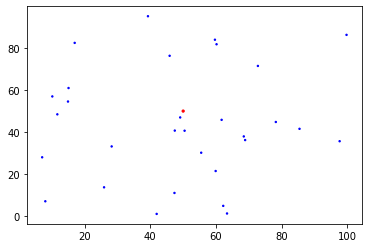

In [36]:
print_nodes(nodes)

Distances

In [37]:
distances, path = d_matrix(nodes)

100%|██████████| 31/31 [00:00<00:00, 36137.69it/s]


Vehicles

In [38]:
# Create a single vehicle object
vehicles = dict(
[("van",vehicle(
        Q=4,
        F=1,
        cd=0.95,
        pathstyle='--',
        vehtype_ID="van"))]
)

## Build Gurobi Model

__Model Formulation__

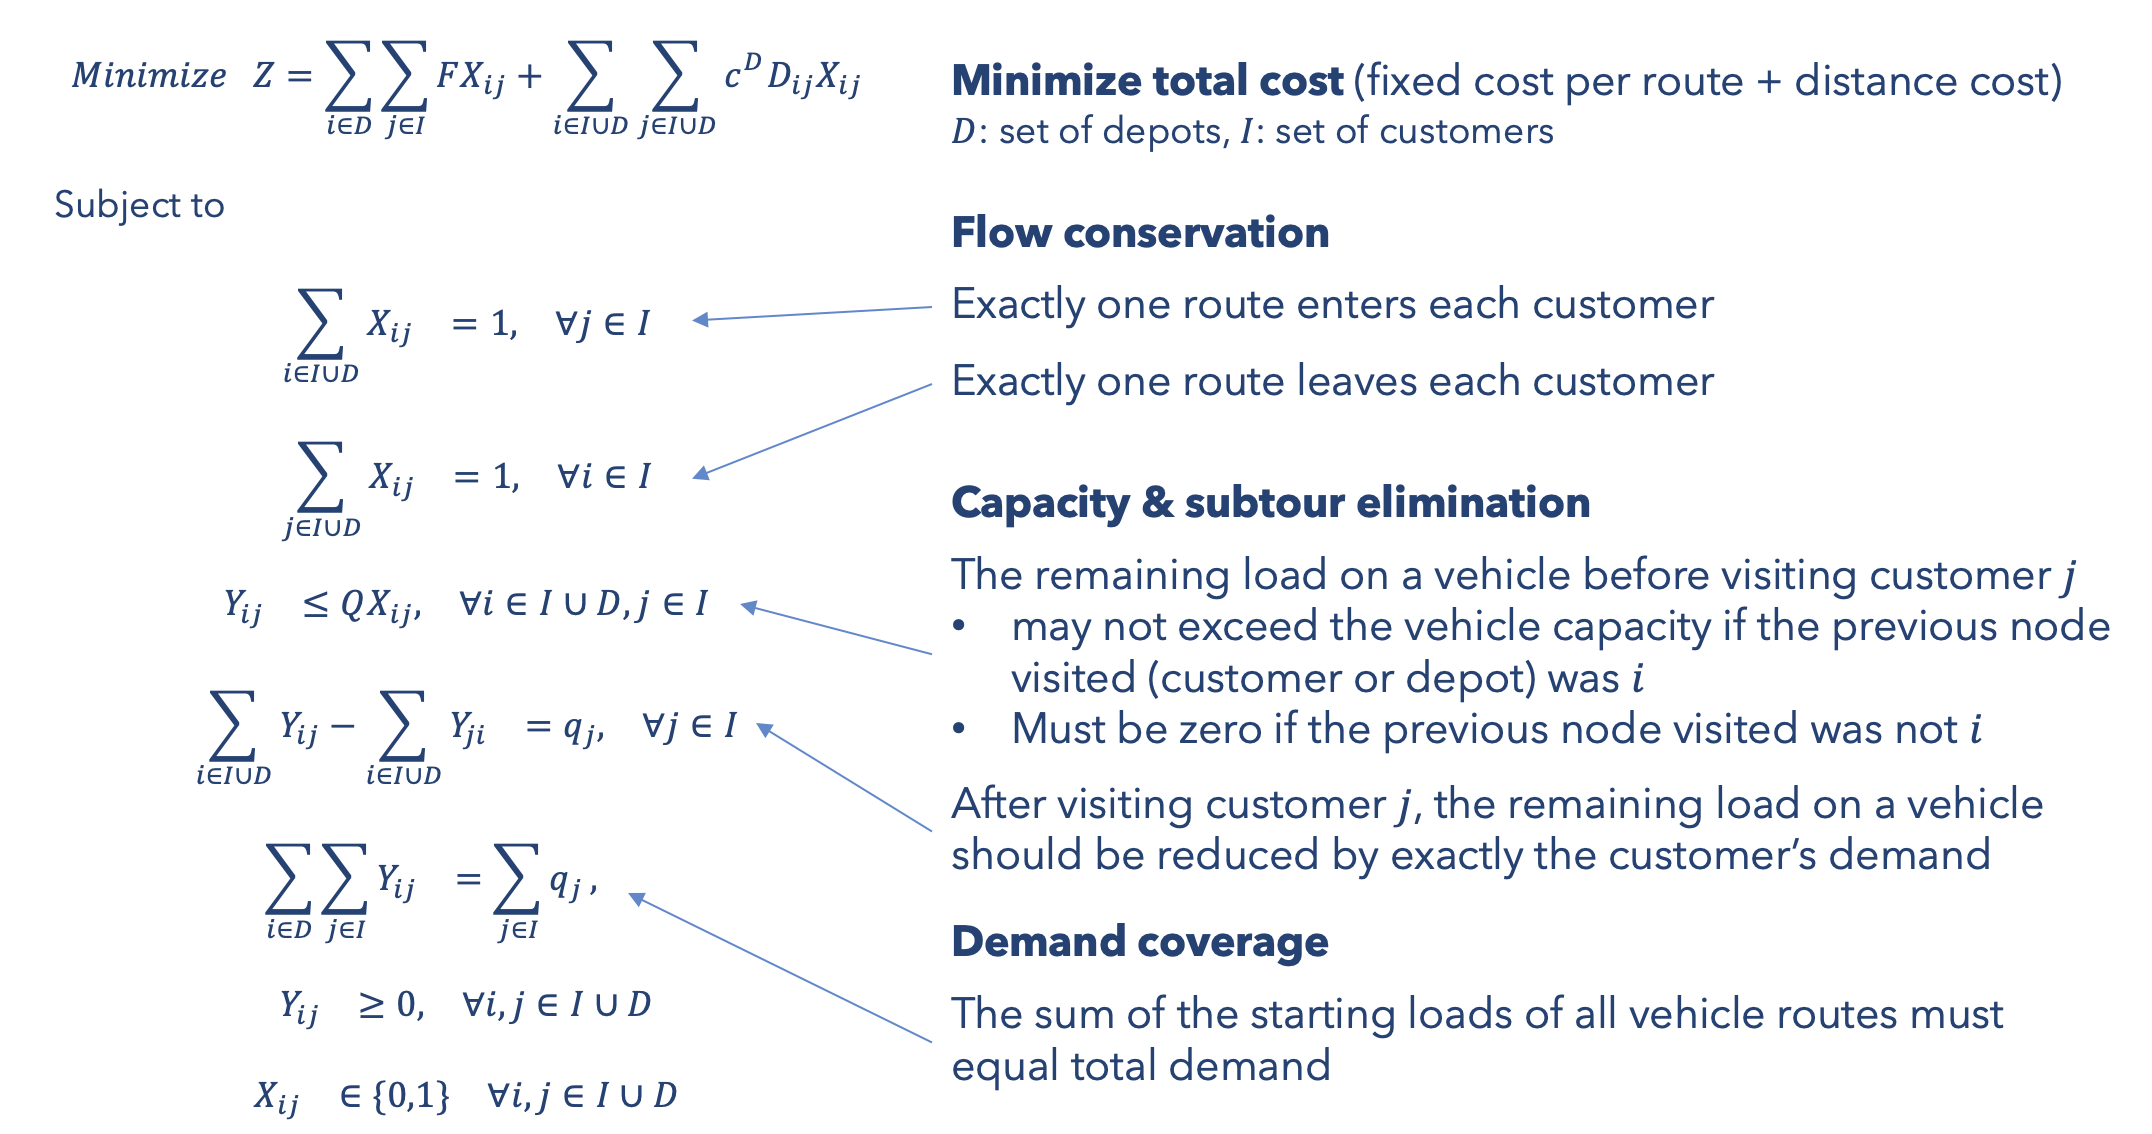

__Initialize New Gurobi Model__

In [39]:
m = gp.Model("VRP")

__Add Decision Variables of Base Model__

- Routing variables (binary)
- Auxiliary variables (integer)

In [40]:
# Create variables
# - Routing decisions on the arcs of the network
X = dict(
    [((i,j), m.addVar(vtype=GRB.BINARY, lb=0.0, ub=1.0, name="x_%s_%s" %(i,j))) 
     for i in nodes 
     for j in nodes]
)

# - Auxiliary variables to track the load of the vehicle
Y = dict(
    [((i,j), m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name="y_%s_%s" %(i,j))) 
     for i in nodes 
     for j in nodes]
)

__Set Optimization Objective__

Minimize total distance travelled

In [41]:
# Set objective: minimiz total cost (fixed per route + variable per distance)
m.setObjective(
    quicksum([vehicles['van'].F * X[(i,j)] 
              for i in depots
              for j in customers])
    + quicksum([distances[(i,j)]*vehicles['van'].cd*X[(i,j)] 
              for i in nodes 
              for j in nodes]), 
               GRB.MINIMIZE)

__Add Constraints of Basic Model__

In [42]:
# Add constraints:

# Exactly one vehicle route enters each customer
C_flow_cons_in = dict(
    [(j,m.addConstr(quicksum([X[(i,j)]  
                              for i in nodes]) == 1, "single_in_%s" %j)) 
     for j in customers]
)

# Exactly one vehicle route leaves each customer
C_flow_cons_out = dict(
    [(i,m.addConstr(quicksum([X[(i,j)] 
                              for j in nodes]) == 1, "single_out_%s" %i)) 
     for i in customers]
)


# 1) The remaining load in a vehicle before visiting customer node j if the previous node visited 
#    was (customer or depot) node i may not exceed the vehicle capacity 
#    ==> never exceed the vehicle capacity!
# 2) The remaining load in a vehicle before visiting customer node j if the previous node visited 
#    was NOT (customer or depot) node i must be zero 
#    ==> each customer can only be part of one route!
C_veh_capa = dict(
    [((i,j),m.addConstr(Y[(i,j)] <= vehicles['van'].Q*X[(i,j)], "capa_%s_%s" %(i,j))) 
     for i in nodes 
     for j in customers]
)

# The remaining load in a vehicle after visiting customer node j minus the remaining load in that vehicle 
# after visiting the next (customer or depot) node must equal the demand of customer node j 
# ==> serve all demand of each customer by exactly one route!
# ==> subtour elimination!
C_serve_each_customer = dict(
    [(j,m.addConstr(quicksum([Y[(i,j)] for i in nodes]) - quicksum([Y[(j,i)] for i in nodes]) == customers[j].q, "each_demand_%s" %j)) 
     for j in customers]
)

# The starting load of all vehicle routes needs to equal total demand
# ==> all demand needs to be served
C_serve_all_demand = dict(
    [('all',m.addConstr(quicksum([Y[(i,j)] 
                              for i in depots 
                              for j in customers]) == sum(customers[j].q for j in customers), "all_demand")) 
     ]
)

# Non-negativity of auxiliary variables Y
C_Nonnegative_Y = dict(
    [((i,j),m.addConstr(Y[(i,j)] >= 0, "nonneg_%s_%s" %(i,j))) 
     for i in nodes 
     for j in nodes]
)

__Run Optimization Model__

In [43]:
m.reset()

# Set model parameters
m.Params.timelimit = 300.0   # run for at most 120 seconds
m.Params.MIPGap = 0.005 # 0.025     # terminate once optimality gap falls below 0.5% / 2.5%

# Optimize model
m.optimize()

Discarded solution information
Changed value of parameter timelimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter MIPGap to 0.005
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 1982 rows, 1922 columns and 6511 nonzeros
Model fingerprint: 0x35c0312b
Variable types: 961 continuous, 961 integer (961 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [2e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 1821.4782706
Presolve removed 1021 rows and 122 columns
Presolve time: 0.03s
Presolved: 961 rows, 1800 columns, 5340 nonzeros
Variable types: 900 continuous, 900 integer (900 binary)

Root relaxation: objective 6.850646e+02, 1453 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Obje

__Plot Solution__

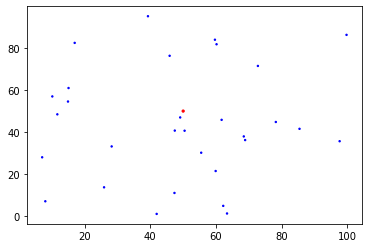

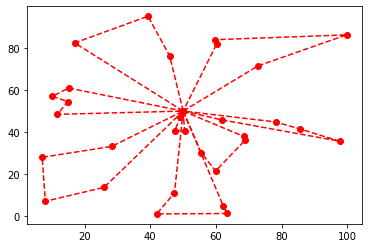

Total Cost: 766.884


In [44]:
print_nodes(nodes)
print_VRP(depots,customers,vehicles,X)
print('Total Cost: %g' % m.objVal)